2025-05-14 15:47:48 - water_infrastructure - INFO - Libraries imported successfully.
2025-05-14 15:47:48 - water_infrastructure - INFO - Configuration set. Current year: 2025
2025-05-14 15:47:48 - water_infrastructure - INFO - DataIngestionAgent initialized.
2025-05-14 15:47:48 - water_infrastructure - INFO - RiskModelingAgent initialized.
2025-05-14 15:47:48 - water_infrastructure - INFO - MaintenancePlanningAgent initialized.
2025-05-14 15:47:48 - water_infrastructure - INFO - UserInteractionAgent initialized.
2025-05-14 15:47:48 - water_infrastructure - INFO - OrchestrationAgent initialized.
2025-05-14 15:47:48 - water_infrastructure - INFO - 
OrchestrationAgent: Starting Baseline Assessment Workflow (n=50)...
2025-05-14 15:47:48 - water_infrastructure - INFO - DataIngestionAgent: Loading mock pipe data (n=50)...
2025-05-14 15:47:48 - water_infrastructure - INFO - DataIngestionAgent: Mock data loaded with realistic distributions.
2025-05-14 15:47:48 - water_infrastructure - INFO - D


               RISK ASSESSMENT SUMMARY
Total Pipes Assessed: 50
Average Risk Score: 5.81
Highest Risk Score: 7.74
Total Pipe Length (km): 7.18
Average Pipe Age (years): 43.7
Estimated Total Replacement Cost: $13,928,000
--------------------------------------------------

RISK CATEGORY DISTRIBUTION:
  Critical: 0 pipes (0.0%)
  High: 5 pipes (10.0%)
  Medium: 34 pipes (68.0%)
  Low: 11 pipes (22.0%)
  Negligible: 0 pipes (0.0%)

TOP 5 HIGHEST RISK PIPES:
  Pipe P0046: 472mm Galvanized Steel pipe, installed 1940, Risk Score: 7.74 (High)
  Pipe P0041: 265mm Cast Iron (Old) pipe, installed 1940, Risk Score: 7.70 (High)
  Pipe P0044: 242mm Clay pipe, installed 1979, Risk Score: 7.66 (High)
  Pipe P0007: 273mm Cast Iron (Old) pipe, installed 1969, Risk Score: 7.29 (High)
  Pipe P0019: 59mm Galvanized Steel pipe, installed 1964, Risk Score: 7.13 (High)
--------------------------------------------------


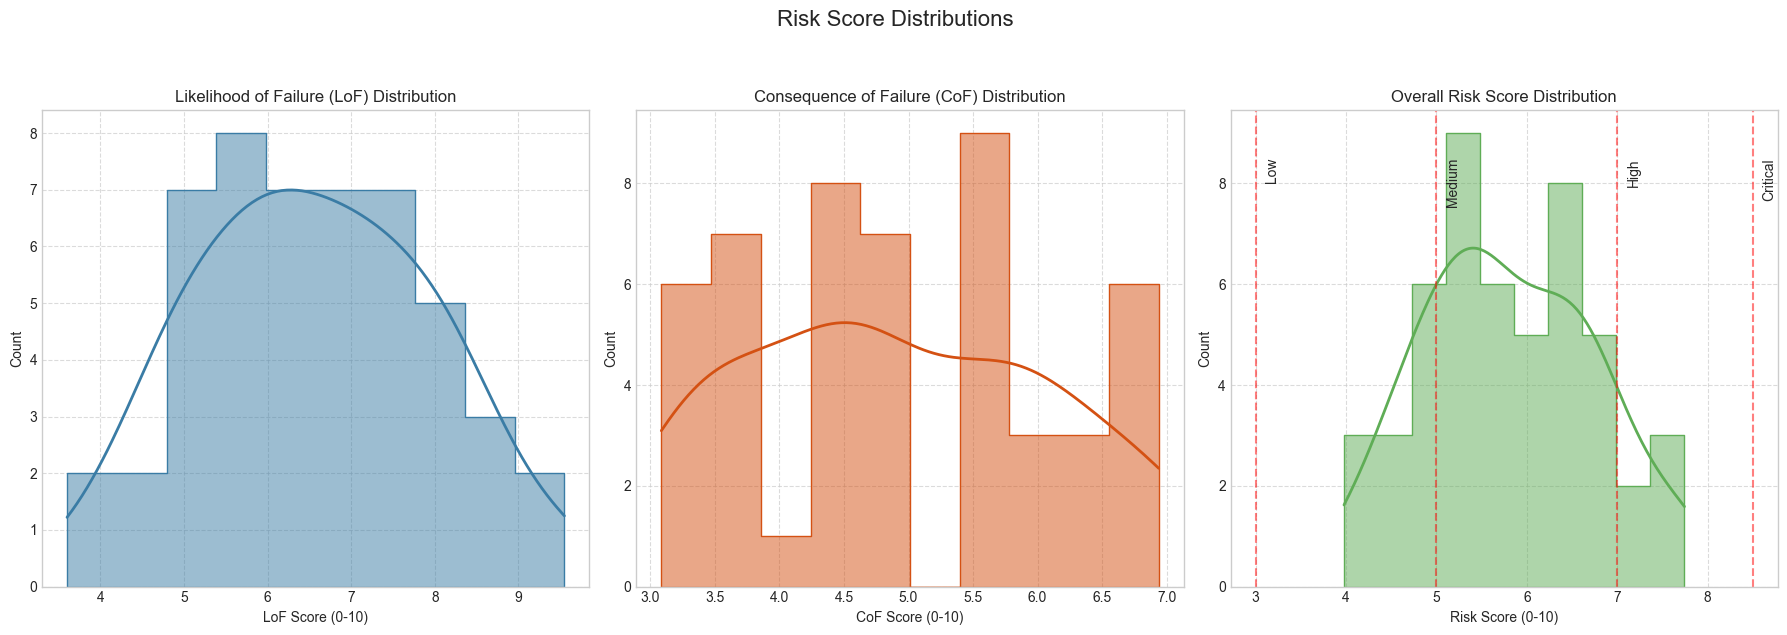

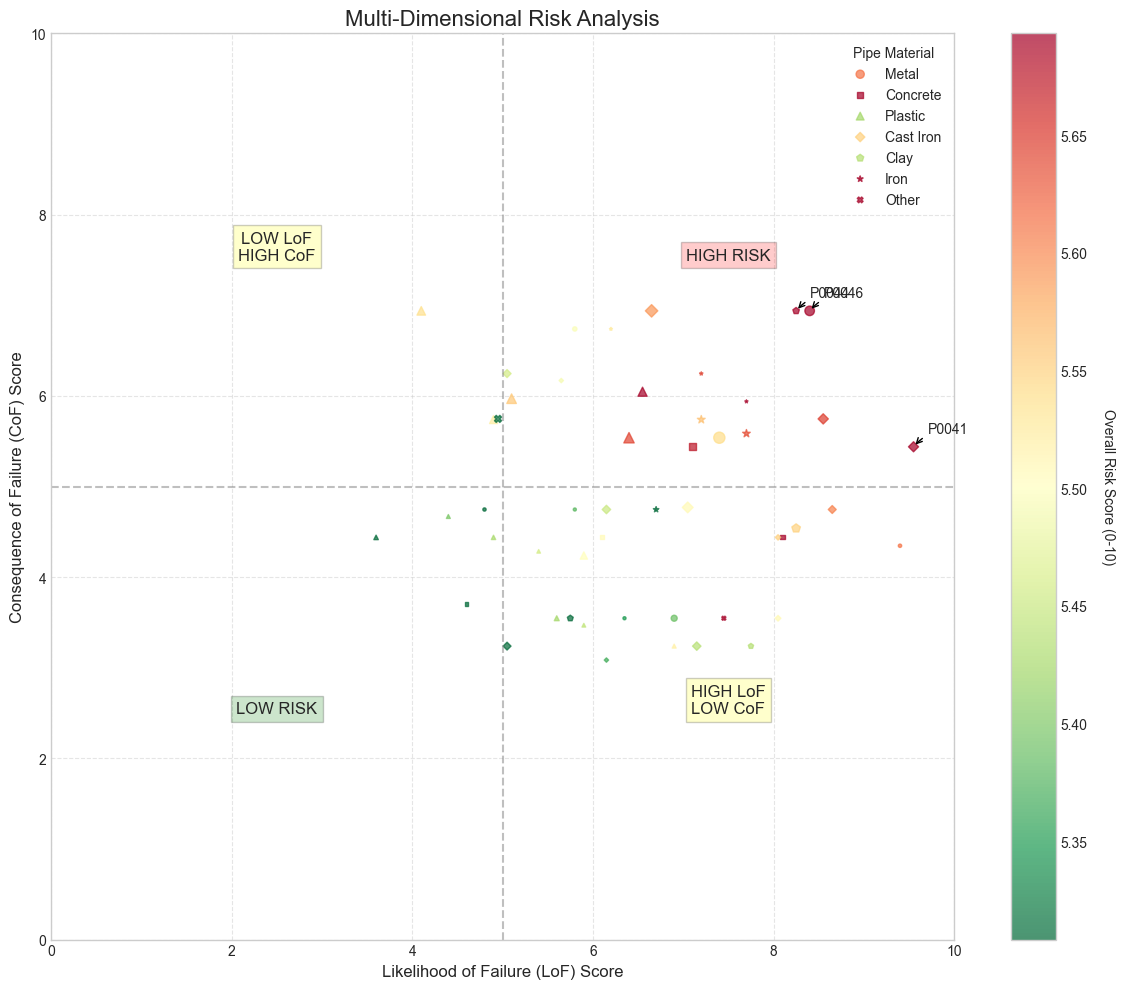

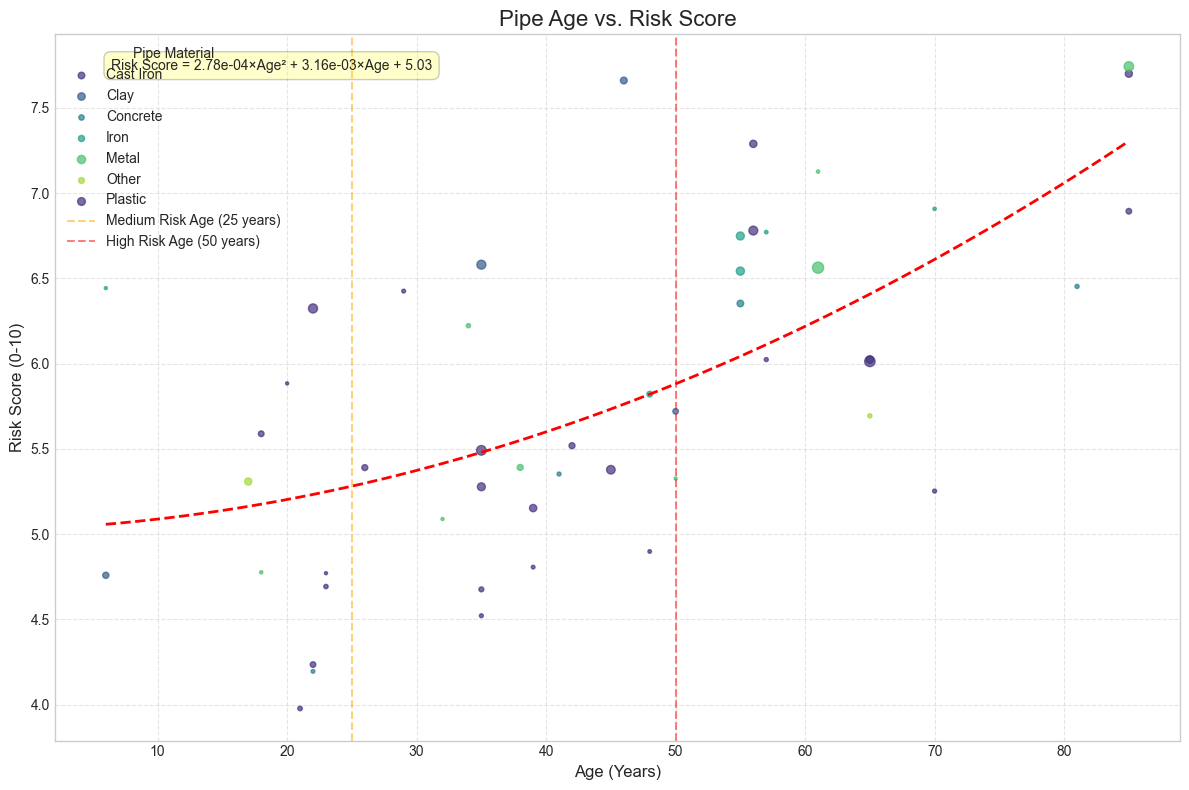

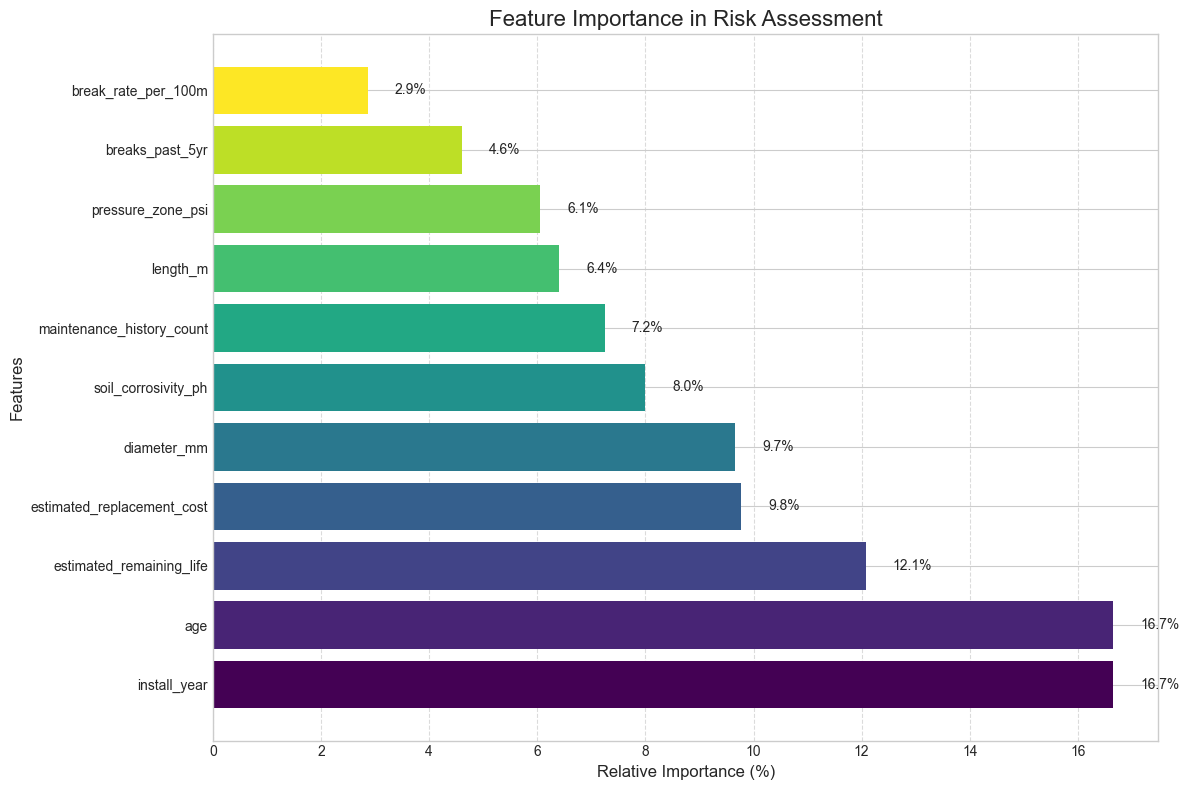

In [ ]:
#
# This script is designed to be run cell-by-cell in a Jupyter Notebook.

# --------------------------------------------------------------------------
# Cell 1: Setup - Import Libraries
# --------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import folium
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm
import logging

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger('water_infrastructure')

# Set default style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

logger.info("Libraries imported successfully.")

# --------------------------------------------------------------------------
# Cell 2: Configuration & Parameters
# --------------------------------------------------------------------------
# Define current year for age calculation
CURRENT_YEAR = datetime.now().year

# Define risk scoring parameters (can be tuned)
AGE_THRESHOLD_CRITICAL_LOF = 75  # Years after which LoF becomes critical
AGE_THRESHOLD_HIGH_LOF = 50      # Years after which LoF increases significantly
AGE_THRESHOLD_MEDIUM_LOF = 25    # Years after which LoF increases moderately

# Material scoring with more detailed categories
MATERIAL_LOF_SCORES = {
    "Cast Iron (Old)": 8.5,
    "Cast Iron (New)": 5.5,
    "Ductile Iron": 4,
    "PVC": 3,
    "HDPE": 2,
    "Steel": 6,
    "Concrete": 7,
    "Asbestos Cement": 9,
    "Clay": 7.5,
    "Galvanized Steel": 8,
    "Copper": 4.5,
    "Brass": 5,
    "Plastic (Other)": 3.5,
    "Unknown": 6.5
}

# Pipe diameter thresholds
DIAMETER_COF_THRESHOLD_CRITICAL = 1000  # mm, above which CoF is critical
DIAMETER_COF_THRESHOLD_HIGH = 500       # mm, above which CoF is high
DIAMETER_COF_THRESHOLD_MEDIUM = 200     # mm, above which CoF is medium

# Criticality categories with scores
CRITICALITY_COF_SCORES = {
    "Critical": 10,    # e.g., supplies critical infrastructure like hospitals
    "High": 8,         # e.g., supplies hospital, major industry
    "Medium": 5,       # e.g., supplies school, dense residential
    "Low": 2,          # e.g., supplies sparse residential, park
    "Unknown": 4       # Default for unknown criticality
}

# Location-based risk modifiers
LOCATION_RISK_MODIFIERS = {
    "Urban Core": 1.2,       # Increased impact due to density
    "Industrial Zone": 1.15,  # Potential contaminant risks
    "Residential": 1.0,      # Baseline
    "Rural": 0.9,            # Generally lower impact
    "Environmentally Sensitive": 1.3  # Higher environmental impact risk
}

# Weights for overall risk score calculation
LOF_WEIGHT = 0.55       # Increased slightly as likelihood often drives maintenance
COF_WEIGHT = 0.45       # Still significant but slightly reduced

# Risk category thresholds
RISK_THRESHOLDS = {
    "Critical": 8.5,
    "High": 7.0,
    "Medium": 5.0,
    "Low": 3.0,
    "Negligible": 0.0
}

# Budget constraints for maintenance planning
ANNUAL_MAINTENANCE_BUDGET = 1000000  # $ - Example budget
REPLACEMENT_COST_PER_METER = {
    "Small (≤ 200mm)": 1000,      # $ per meter
    "Medium (201-500mm)": 2500,   # $ per meter
    "Large (> 500mm)": 5000       # $ per meter
}

logger.info(f"Configuration set. Current year: {CURRENT_YEAR}")

# --------------------------------------------------------------------------
# Cell 3: Agent Simulation - Data Ingestion Agent
# --------------------------------------------------------------------------


class DataIngestionAgent:
    """
    Simulates the Data Ingestion Agent with enhanced data handling capabilities.

    Responsibilities:
    - Automates ingestion from various sources (here, mock data).
    - Normalizes and cleans incoming datasets.
    - Detects missing data and triggers data-collection tasks.
    - Performs basic validation and quality checks.
    """

    def __init__(self):
        self.raw_data = None
        self.processed_data = None
        self.data_quality_metrics = {}
        logger.info("DataIngestionAgent initialized.")

    def load_mock_pipe_data(self, sample_size=40):
        """
        Loads enhanced mock pipe inventory data with more realistic distribution.

        Args:
            sample_size: Number of pipe records to generate

        Returns:
            DataFrame containing mock pipe data
        """
        logger.info(
            f"DataIngestionAgent: Loading mock pipe data (n={sample_size})...")

        # Generate realistic pipe IDs
        pipe_ids = [f'P{i:04}' for i in range(1, sample_size + 1)]

        # Generate realistic installation years with a distribution skewed toward older pipes
        years = np.random.choice(
            np.concatenate([
                np.random.normal(1965, 10, size=int(
                    sample_size * 0.3)),  # Older pipes
                np.random.normal(1985, 8, size=int(
                    sample_size * 0.3)),   # Middle-aged pipes
                np.random.normal(2005, 7, size=int(
                    sample_size * 0.4))    # Newer pipes
            ]),
            size=sample_size
        ).astype(int)
        # Ensure years are between 1940 and current year
        years = np.clip(years, 1940, CURRENT_YEAR)

        # Generate realistic materials with appropriate distributions
        materials = np.random.choice(
            list(MATERIAL_LOF_SCORES.keys()),
            size=sample_size,
            p=[0.15, 0.1, 0.15, 0.2, 0.1, 0.05, 0.05,
                0.05, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02]
        )

        # Generate diameters with realistic distribution (skewed toward smaller sizes)
        diameters = np.concatenate([
            np.random.lognormal(mean=4.5, sigma=0.5, size=int(
                sample_size * 0.6)),  # Small pipes
            np.random.lognormal(mean=5.5, sigma=0.4, size=int(
                sample_size * 0.3)),  # Medium pipes
            np.random.lognormal(mean=6.2, sigma=0.3, size=int(
                sample_size * 0.1))   # Large pipes
        ])
        diameters = np.clip(diameters, 50, 1200).astype(
            int)  # Constrain to realistic range

        # Generate pipe lengths - usually distributed around certain standard lengths
        lengths = np.concatenate([
            np.random.normal(75, 15, size=int(
                sample_size * 0.4)),    # Short segments
            np.random.normal(150, 30, size=int(
                sample_size * 0.4)),   # Medium segments
            np.random.normal(250, 50, size=int(
                sample_size * 0.2))    # Long segments
        ])
        lengths = np.clip(lengths, 20, 400).astype(
            int)  # Constrain to realistic range

        # Generate criticality with weighted distribution
        criticality = np.random.choice(
            list(CRITICALITY_COF_SCORES.keys()),
            size=sample_size,
            # Most pipes are low/medium criticality
            p=[0.05, 0.15, 0.35, 0.4, 0.05]
        )

        # Generate location type
        location_type = np.random.choice(
            list(LOCATION_RISK_MODIFIERS.keys()),
            size=sample_size,
            p=[0.30, 0.15, 0.40, 0.10, 0.05]
        )

        # Generate maintenance history - count of past interventions
        maintenance_history = np.random.poisson(lam=1.5, size=sample_size)

        # Generate number of breaks/leaks in past 5 years
        past_breaks = np.random.poisson(lam=0.8, size=sample_size)

        # Generate pressure zone (psi)
        pressure_zones = np.concatenate([
            np.random.normal(45, 5, size=int(
                sample_size * 0.3)),   # Low pressure
            np.random.normal(65, 8, size=int(
                sample_size * 0.5)),   # Medium pressure
            np.random.normal(85, 5, size=int(
                sample_size * 0.2))    # High pressure
        ])
        pressure_zones = np.clip(pressure_zones, 30, 100).astype(int)

        # Generate soil corrosivity (pH scale 0-14)
        soil_corrosivity = np.random.normal(7.0, 1.5, size=sample_size)
        soil_corrosivity = np.clip(soil_corrosivity, 3, 10).round(1)

        # Generate x, y coordinates for a small fictional city area (with some clustering)
        # Create clusters for different city zones
        num_clusters = 5
        cluster_centers = np.random.uniform(
            low=0, high=100, size=(num_clusters, 2))
        cluster_assignments = np.random.choice(
            range(num_clusters), size=sample_size)

        x_coords = np.zeros(sample_size)
        y_coords = np.zeros(sample_size)

        for i in range(sample_size):
            # Add random noise around cluster center
            x_coords[i] = cluster_centers[cluster_assignments[i],
                                          0] + np.random.normal(0, 10)
            y_coords[i] = cluster_centers[cluster_assignments[i],
                                          1] + np.random.normal(0, 10)

        # Normalize to 0-100 range for simplicity
        x_coords = np.clip(x_coords, 0, 100)
        y_coords = np.clip(y_coords, 0, 100)

        # Create lat/long for map visualization (fictional coordinates near New York)
        base_lat, base_long = 40.7128, -74.0060
        # Convert x,y to small lat/long offsets
        latitudes = base_lat + (y_coords - 50) * 0.001
        longitudes = base_long + (x_coords - 50) * 0.001

        # Combine all data into a dictionary
        data = {
            'pipe_id': pipe_ids,
            'material': materials,
            'install_year': years,
            'diameter_mm': diameters,
            'length_m': lengths,
            'criticality_category': criticality,
            'location_type': location_type,
            'maintenance_history_count': maintenance_history,
            'breaks_past_5yr': past_breaks,
            'pressure_zone_psi': pressure_zones,
            'soil_corrosivity_ph': soil_corrosivity,
            'x_coord': x_coords,
            'y_coord': y_coords,
            'latitude': latitudes,
            'longitude': longitudes
        }

        # Introduce some missing values to simulate real-world data
        # Create a dataframe first
        df = pd.DataFrame(data)

        # Introduce ~3% missing values in select columns
        missing_mask = np.random.random(size=df.shape) < 0.03
        cols_with_missing = ['material', 'install_year', 'diameter_mm',
                             'maintenance_history_count', 'soil_corrosivity_ph']
        for col in cols_with_missing:
            col_idx = df.columns.get_loc(col)
            df.iloc[:, col_idx] = df.iloc[:, col_idx].mask(
                missing_mask[:, col_idx])

        self.raw_data = df

        # Calculate data quality metrics
        self._calculate_data_quality_metrics()

        logger.info(
            "DataIngestionAgent: Mock data loaded with realistic distributions.")
        return self.raw_data

    def _calculate_data_quality_metrics(self):
        """Calculate and store data quality metrics."""
        if self.raw_data is None:
            return

        # Calculate completeness by column
        completeness = (1 - self.raw_data.isna().mean()) * 100

        # Calculate value range metrics
        numerical_columns = self.raw_data.select_dtypes(
            include=[np.number]).columns
        ranges = {col: {
            'min': self.raw_data[col].min(),
            'max': self.raw_data[col].max(),
            'mean': self.raw_data[col].mean(),
            'median': self.raw_data[col].median()
        } for col in numerical_columns if not self.raw_data[col].isna().all()}

        # Store metrics
        self.data_quality_metrics = {
            'record_count': len(self.raw_data),
            'column_count': len(self.raw_data.columns),
            'completeness_pct': completeness,
            'value_ranges': ranges
        }

    def preprocess_data(self, df=None):
        """
        Performs cleaning, feature engineering, and imputation.

        Args:
            df: DataFrame to process, defaults to self.raw_data if None

        Returns:
            Processed DataFrame with complete values and engineered features
        """
        logger.info("DataIngestionAgent: Preprocessing data...")

        if df is None:
            if self.raw_data is None:
                logger.error("No data available for preprocessing.")
                return None
            df = self.raw_data.copy()
        else:
            df = df.copy()

        # Calculate age
        df['age'] = CURRENT_YEAR - df['install_year']

        # Add diameter category for cost estimation
        conditions = [
            (df['diameter_mm'] <= 200),
            (df['diameter_mm'] > 200) & (df['diameter_mm'] <= 500),
            (df['diameter_mm'] > 500)
        ]
        choices = ["Small (≤ 200mm)", "Medium (201-500mm)", "Large (> 500mm)"]
        df['diameter_category'] = np.select(
            conditions, choices, default="Small (≤ 200mm)")

        # Replace missing materials with "Unknown"
        df['material'].fillna('Unknown', inplace=True)

        # Impute missing installation years based on material and diameter
        if df['install_year'].isna().any():
            # Group by material to find typical installation years
            material_year_median = df.groupby(
                'material')['install_year'].median()

            # For each missing installation year, impute based on material
            for idx in df[df['install_year'].isna()].index:
                material = df.loc[idx, 'material']
                if material in material_year_median and not np.isnan(material_year_median[material]):
                    df.loc[idx, 'install_year'] = material_year_median[material]
                else:
                    # If no data for that material, use overall median
                    df.loc[idx, 'install_year'] = df['install_year'].median()

            # Recalculate age
            df['age'] = CURRENT_YEAR - df['install_year']

        # Impute missing diameter with median by material type
        if df['diameter_mm'].isna().any():
            material_diameter_median = df.groupby(
                'material')['diameter_mm'].median()
            for idx in df[df['diameter_mm'].isna()].index:
                material = df.loc[idx, 'material']
                if material in material_diameter_median and not np.isnan(material_diameter_median[material]):
                    df.loc[idx, 'diameter_mm'] = material_diameter_median[material]
                else:
                    df.loc[idx, 'diameter_mm'] = df['diameter_mm'].median()

            # Update diameter category
            conditions = [
                (df['diameter_mm'] <= 200),
                (df['diameter_mm'] > 200) & (df['diameter_mm'] <= 500),
                (df['diameter_mm'] > 500)
            ]
            choices = ["Small (≤ 200mm)", "Medium (201-500mm)",
                       "Large (> 500mm)"]
            df['diameter_category'] = np.select(
                conditions, choices, default="Small (≤ 200mm)")

        # Impute other missing values
        df['maintenance_history_count'].fillna(
            df['maintenance_history_count'].median(), inplace=True)
        df['soil_corrosivity_ph'].fillna(
            df['soil_corrosivity_ph'].median(), inplace=True)

        # Create a derived feature for break rate (breaks per length)
        df['break_rate_per_100m'] = df['breaks_past_5yr'] / \
            (df['length_m'] / 100)

        # Calculate estimated remaining life based on age and material
        typical_lifespans = {
            "Cast Iron (Old)": 75,
            "Cast Iron (New)": 100,
            "Ductile Iron": 110,
            "PVC": 80,
            "HDPE": 95,
            "Steel": 85,
            "Concrete": 65,
            "Asbestos Cement": 60,
            "Clay": 60,
            "Galvanized Steel": 50,
            "Copper": 80,
            "Brass": 85,
            "Plastic (Other)": 75,
            "Unknown": 70
        }

        # Calculate remaining life as percentage of typical lifespan
        df['estimated_remaining_life'] = df.apply(
            lambda row: max(0, typical_lifespans.get(
                row['material'], 70) - row['age']),
            axis=1
        )

        # Calculate replacement cost based on length and diameter category
        df['estimated_replacement_cost'] = df.apply(
            lambda row: row['length_m'] *
            REPLACEMENT_COST_PER_METER.get(row['diameter_category'], 1000),
            axis=1
        )

        self.processed_data = df
        logger.info("DataIngestionAgent: Data preprocessing complete.")
        return self.processed_data

    def get_data_quality_report(self):
        """Generate a data quality report for visualization."""
        if not self.data_quality_metrics:
            self._calculate_data_quality_metrics()

        return {
            'completeness': self.data_quality_metrics['completeness_pct'].to_dict(),
            'record_count': self.data_quality_metrics['record_count'],
            'column_count': self.data_quality_metrics['column_count']
        }


# --------------------------------------------------------------------------
# Cell 4: Agent Simulation - Risk Modeling Agent
# --------------------------------------------------------------------------
class RiskModelingAgent:
    """
    Simulates the Risk Modeling Agent with enhanced risk scoring.

    Responsibilities:
    - Executes risk assessment pipelines
    - Generates composite risk scores
    - Provides feature explanations
    - Identifies key risk factors
    """

    def __init__(self):
        self.risk_factors = {}
        self.feature_importances = {}
        logger.info("RiskModelingAgent initialized.")

    def calculate_lof_score(self, pipe_series):
        """
        Calculates Likelihood of Failure (LoF) score (0-10).

        Args:
            pipe_series: Series containing a single pipe's data

        Returns:
            LoF score from 0-10
        """
        lof_components = {}

        # Age-based LoF (0-4 points)
        if pipe_series['age'] > AGE_THRESHOLD_CRITICAL_LOF:
            age_lof = 4.0
        elif pipe_series['age'] > AGE_THRESHOLD_HIGH_LOF:
            age_lof = 3.0
        elif pipe_series['age'] > AGE_THRESHOLD_MEDIUM_LOF:
            age_lof = 2.0
        else:
            age_lof = 1.0
        lof_components['age'] = age_lof

        # Material-based LoF (0-3 points)
        material_lof = MATERIAL_LOF_SCORES.get(
            pipe_series['material'], 5.0) * 0.3  # Scale to 0-3 range
        lof_components['material'] = material_lof

        # Break history based LoF (0-3 points)
        if 'breaks_past_5yr' in pipe_series:
            if pipe_series['breaks_past_5yr'] >= 3:
                break_lof = 3.0
            elif pipe_series['breaks_past_5yr'] >= 1:
                break_lof = 2.0
            else:
                break_lof = 0.5
            lof_components['break_history'] = break_lof
        else:
            lof_components['break_history'] = 0

        # Soil corrosivity impact (0-1.5 points)
        if 'soil_corrosivity_ph' in pipe_series:
            # Acidic or very alkaline soils are more corrosive
            ph = pipe_series['soil_corrosivity_ph']
            if ph < 5 or ph > 9:
                soil_lof = 1.5
            elif ph < 6 or ph > 8.5:
                soil_lof = 1.0
            else:
                soil_lof = 0.5
            lof_components['soil'] = soil_lof
        else:
            lof_components['soil'] = 0

        # Pressure zone impact (0-1.5 points)
        if 'pressure_zone_psi' in pipe_series:
            # Higher pressure = higher stress
            pressure = pipe_series['pressure_zone_psi']
            if pressure > 80:
                pressure_lof = 1.5
            elif pressure > 65:
                pressure_lof = 1.0
            else:
                pressure_lof = 0.5
            lof_components['pressure'] = pressure_lof
        else:
            lof_components['pressure'] = 0

        # Calculate total LoF
        lof = sum(lof_components.values())

        # Cap at 10
        lof = min(lof, 10)

        # Store components for this pipe
        pipe_id = pipe_series['pipe_id']
        self.risk_factors[pipe_id] = self.risk_factors.get(pipe_id, {})
        self.risk_factors[pipe_id]['lof_components'] = lof_components

        return lof

    def calculate_cof_score(self, pipe_series):
        """
        Calculates Consequence of Failure (CoF) score (0-10).

        Args:
            pipe_series: Series containing a single pipe's data

        Returns:
            CoF score from 0-10
        """
        cof_components = {}

        # Diameter-based CoF (0-3 points)
        if pipe_series['diameter_mm'] > DIAMETER_COF_THRESHOLD_CRITICAL:
            diameter_cof = 3.0
        elif pipe_series['diameter_mm'] > DIAMETER_COF_THRESHOLD_HIGH:
            diameter_cof = 2.5
        elif pipe_series['diameter_mm'] > DIAMETER_COF_THRESHOLD_MEDIUM:
            diameter_cof = 1.5
        else:
            diameter_cof = 0.5
        cof_components['diameter'] = diameter_cof

        # Criticality-based CoF (0-4 points)
        criticality_cof = CRITICALITY_COF_SCORES.get(
            pipe_series['criticality_category'], 4) * 0.4
        cof_components['criticality'] = criticality_cof

        # Location-based CoF modifier (0-2 points)
        if 'location_type' in pipe_series:
            location_modifier = LOCATION_RISK_MODIFIERS.get(
                pipe_series['location_type'], 1.0)
            location_cof = 2.0 * location_modifier / 1.3  # Normalize to 0-2 scale
            cof_components['location'] = location_cof
        else:
            cof_components['location'] = 1.0

        # Estimated service disruption impact based on pipe size and criticality (0-1 point)
        if pipe_series['diameter_mm'] > 500 and pipe_series['criticality_category'] in ['Critical', 'High']:
            disruption_cof = 1.0
        elif pipe_series['diameter_mm'] > 300 or pipe_series['criticality_category'] in ['Critical', 'High']:
            disruption_cof = 0.7
        else:
            disruption_cof = 0.4
        cof_components['disruption'] = disruption_cof

        # Calculate total CoF
        cof = sum(cof_components.values())

        # Cap at 10
        cof = min(cof, 10)

        # Store components for this pipe
        pipe_id = pipe_series['pipe_id']
        self.risk_factors[pipe_id] = self.risk_factors.get(pipe_id, {})
        self.risk_factors[pipe_id]['cof_components'] = cof_components

        return cof

    def assess_risk(self, df):
        """
        Calculates LoF, CoF, and Overall Risk scores for each pipe.

        Args:
            df: DataFrame containing pipe data

        Returns:
            DataFrame with added risk scores and categories
        """
        logger.info("RiskModelingAgent: Assessing risk...")
        risk_df = df.copy()

        # Reset risk factors for a new assessment
        self.risk_factors = {}

        # Calculate risk scores
        risk_df['lof_score'] = risk_df.apply(self.calculate_lof_score, axis=1)
        risk_df['cof_score'] = risk_df.apply(self.calculate_cof_score, axis=1)

        # Calculate business risk exposure (BRE)
        risk_df['overall_risk_score'] = (LOF_WEIGHT * risk_df['lof_score'] +
                                         COF_WEIGHT * risk_df['cof_score'])

        # Categorize risk
        risk_df['risk_category'] = pd.cut(
            risk_df['overall_risk_score'],
            bins=[0, RISK_THRESHOLDS['Low'], RISK_THRESHOLDS['Medium'],
                  RISK_THRESHOLDS['High'], RISK_THRESHOLDS['Critical'], 10],
            labels=['Negligible', 'Low', 'Medium', 'High', 'Critical'],
            right=True,
            include_lowest=True
        )

        # Calculate a normalized risk score (0-100) for easier interpretation
        risk_df['risk_score_normalized'] = risk_df['overall_risk_score'] * 10

        # Calculate replacement priority index based on risk and cost-effectiveness
        risk_df['priority_index'] = (
            risk_df['overall_risk_score'] * 10 /
            (risk_df['estimated_replacement_cost'] / 1000)
        )

        # Add fiscal year recommendations based on risk category
        conditions = [
            (risk_df['risk_category'] == 'Critical'),
            (risk_df['risk_category'] == 'High'),
            (risk_df['risk_category'] == 'Medium'),
            (risk_df['risk_category'] == 'Low'),
            (risk_df['risk_category'] == 'Negligible')
        ]
        recommended_fy = [
            f"FY{datetime.now().year}",
            f"FY{datetime.now().year + 1}",
            f"FY{datetime.now().year + 2}-{datetime.now().year + 5}",
            f"FY{datetime.now().year + 5}-{datetime.now().year + 10}",
            "Monitoring Only"
        ]
        risk_df['recommended_action_timeframe'] = np.select(
            conditions, recommended_fy)

        # Calculate feature importances based on correlation with risk score
        self._calculate_feature_importances(risk_df)

        logger.info("RiskModelingAgent: Risk assessment complete.")
        return risk_df

    def _calculate_feature_importances(self, df):
        """Calculate correlation-based feature importances."""
        # Select numerical columns
        numerical_cols = df.select_dtypes(include=[np.number]).columns
        numerical_cols = [col for col in numerical_cols if col not in [
            'overall_risk_score', 'lof_score', 'cof_score', 'risk_score_normalized',
            'priority_index', 'x_coord', 'y_coord', 'latitude', 'longitude'
        ]]

        # Calculate correlations with risk score
        if numerical_cols:
            correlations = df[numerical_cols].corrwith(
                df['overall_risk_score']).abs()
            # Normalize to sum to 100%
            self.feature_importances = (
                correlations / correlations.sum() * 100).to_dict()

    def get_risk_factors_for_pipe(self, pipe_id):
        """Return detailed risk factors for a specific pipe."""
        return self.risk_factors.get(pipe_id, {})

    def get_feature_importances(self):
        """Return calculated feature importances."""
        return self.feature_importances


# --------------------------------------------------------------------------
# Cell 5: Agent Simulation - Maintenance Planning Agent (New)
# --------------------------------------------------------------------------
class MaintenancePlanningAgent:
    """
    Simulates the Maintenance Planning Agent.

    Responsibilities:
    - Creates optimized maintenance plans based on risk assessment
    - Estimates budget requirements
    - Performs cost-benefit analysis
    - Suggests prioritized action plans
    """

    def __init__(self):
        self.maintenance_plan = None
        self.budget_allocation = {}
        logger.info("MaintenancePlanningAgent initialized.")

    def generate_maintenance_plan(self, risk_df):
        """
        Generates a maintenance plan based on risk scores and budget constraints.

        Args:
            risk_df: DataFrame with risk assessment results

        Returns:
            DataFrame with maintenance recommendations and budget allocations
        """
        logger.info("MaintenancePlanningAgent: Generating maintenance plan...")

        # Create a copy to avoid modifying the original
        plan_df = risk_df.copy()

        # Define maintenance actions and costs based on risk category
        maintenance_actions = {
            'Critical': 'Replace',
            'High': 'Rehabilitation/Replace',
            'Medium': 'Targeted Rehabilitation',
            'Low': 'Condition Assessment',
            'Negligible': 'Regular Monitoring'
        }

        # Maintenance cost as a percentage of full replacement cost
        maintenance_cost_factors = {
            'Replace': 1.0,  # 100% of replacement cost
            'Rehabilitation/Replace': 0.7,  # 70% of replacement cost
            'Targeted Rehabilitation': 0.35,  # 35% of replacement cost
            'Condition Assessment': 0.1,  # 10% of replacement cost
            'Regular Monitoring': 0.02  # 2% of replacement cost
        }

        # Assign recommended actions and estimated costs
        plan_df['recommended_action'] = plan_df['risk_category'].map(
            maintenance_actions)
        plan_df['maintenance_cost'] = plan_df.apply(
            lambda row: row['estimated_replacement_cost'] *
            maintenance_cost_factors[maintenance_actions[row['risk_category']]],
            axis=1
        )

        # Sort by priority index (descending)
        plan_df = plan_df.sort_values('priority_index', ascending=False)

        # Calculate cumulative cost
        plan_df['cumulative_cost'] = plan_df['maintenance_cost'].cumsum()

        # Determine what can be done within budget
        plan_df['within_annual_budget'] = plan_df['cumulative_cost'] <= ANNUAL_MAINTENANCE_BUDGET

        # Assign fiscal years for planning based on budget constraints
        budget_remaining = ANNUAL_MAINTENANCE_BUDGET
        current_fy = datetime.now().year
        plan_df['planned_fiscal_year'] = None

        for i, row in plan_df.iterrows():
            if budget_remaining >= row['maintenance_cost']:
                plan_df.at[i, 'planned_fiscal_year'] = f"FY{current_fy}"
                budget_remaining -= row['maintenance_cost']
            elif budget_remaining > 0:
                # Partial funding this year, complete next year
                plan_df.at[i,
                           'planned_fiscal_year'] = f"FY{current_fy}-FY{current_fy+1}"
                budget_remaining = 0
            else:
                # Move to next fiscal year
                current_fy += 1
                budget_remaining = ANNUAL_MAINTENANCE_BUDGET
                if budget_remaining >= row['maintenance_cost']:
                    plan_df.at[i, 'planned_fiscal_year'] = f"FY{current_fy}"
                    budget_remaining -= row['maintenance_cost']
                else:
                    plan_df.at[i, 'planned_fiscal_year'] = f"FY{current_fy}+"

        # Calculate budget allocation by risk category
        budget_by_category = plan_df.groupby('risk_category')[
            'maintenance_cost'].sum().to_dict()
        total_budget_needs = plan_df['maintenance_cost'].sum()

        self.budget_allocation = {
            'by_category': budget_by_category,
            'total_needs': total_budget_needs,
            'annual_budget': ANNUAL_MAINTENANCE_BUDGET,
            'funding_gap': max(0, total_budget_needs - ANNUAL_MAINTENANCE_BUDGET),
            'budget_coverage_pct': min(100, (ANNUAL_MAINTENANCE_BUDGET / total_budget_needs) * 100)
        }

        self.maintenance_plan = plan_df
        logger.info("MaintenancePlanningAgent: Maintenance plan generated.")
        return plan_df

    def get_budget_allocation(self):
        """Returns the budget allocation summary."""
        return self.budget_allocation

    def generate_multi_year_funding_scenario(self, risk_df, years=5, annual_budget_increase=0.03):
        """
        Generates a multi-year funding scenario with projected needs.

        Args:
            risk_df: DataFrame with risk assessment results
            years: Number of years to project
            annual_budget_increase: Annual percentage increase in budget

        Returns:
            DataFrame with multi-year funding projection
        """
        logger.info(
            f"MaintenancePlanningAgent: Generating {years}-year funding scenario...")

        # First year's plan is the base
        if self.maintenance_plan is None:
            self.generate_maintenance_plan(risk_df)

        # Create projection dataframe
        projection = []

        # First year is from current plan
        current_budget = ANNUAL_MAINTENANCE_BUDGET
        remaining_needs = self.budget_allocation['total_needs']

        for year in range(years):
            fiscal_year = datetime.now().year + year

            if year > 0:
                # Increase budget according to parameter
                current_budget *= (1 + annual_budget_increase)

                # Assume aging infrastructure increases needs by 2% annually
                remaining_needs *= 1.02

            # Calculate how much of need is covered
            covered_amount = min(current_budget, remaining_needs)
            coverage_pct = (covered_amount / remaining_needs) * 100

            # Update remaining needs
            remaining_needs -= covered_amount
            if remaining_needs < 0:
                remaining_needs = 0

            projection.append({
                'fiscal_year': f"FY{fiscal_year}",
                'projected_budget': current_budget,
                'estimated_needs': remaining_needs + covered_amount,
                'coverage_pct': coverage_pct,
                'funding_gap': max(0, remaining_needs)
            })

        projection_df = pd.DataFrame(projection)
        return projection_df


# --------------------------------------------------------------------------
# Cell 6: Agent Simulation - Orchestration Agent
# --------------------------------------------------------------------------
class OrchestrationAgent:
    """
    Simulates the Orchestration Agent.

    Responsibilities:
    - Coordinates workflow between agents
    - Handles error recovery and logging
    - Maintains state during multi-step processes
    """

    def __init__(self, data_ingestion_agent, risk_modeling_agent, maintenance_planning_agent=None):
        self.data_agent = data_ingestion_agent
        self.risk_agent = risk_modeling_agent
        self.maintenance_agent = maintenance_planning_agent
        self.workflow_state = {}
        self.execution_history = []
        logger.info("OrchestrationAgent initialized.")

    def run_baseline_assessment_workflow(self, sample_size=40):
        """
        Runs the initial data ingestion and risk assessment workflow.

        Args:
            sample_size: Number of pipe records to generate

        Returns:
            DataFrame with completed risk assessment
        """
        logger.info(
            f"\nOrchestrationAgent: Starting Baseline Assessment Workflow (n={sample_size})...")

        workflow_start_time = datetime.now()
        self.execution_history = []

        try:
            # 1. Ingest Data
            self._record_step("data_ingestion", "started")
            raw_data = self.data_agent.load_mock_pipe_data(sample_size)
            if raw_data is None or raw_data.empty:
                logger.error(
                    "OrchestrationAgent: No data available for processing.")
                self._record_step("data_ingestion", "failed",
                                  "No data available")
                return None
            self._record_step("data_ingestion", "completed",
                              f"{len(raw_data)} records loaded")

            # 2. Preprocess Data
            self._record_step("data_preprocessing", "started")
            processed_data = self.data_agent.preprocess_data(raw_data)
            if processed_data is None or processed_data.empty:
                logger.error("OrchestrationAgent: Data preprocessing failed.")
                self._record_step("data_preprocessing",
                                  "failed", "Preprocessing error")
                return None
            self._record_step("data_preprocessing", "completed",
                              f"{len(processed_data)} records processed")

            # 3. Assess Risk
            self._record_step("risk_assessment", "started")
            risk_assessed_data = self.risk_agent.assess_risk(processed_data)
            if risk_assessed_data is None or risk_assessed_data.empty:
                logger.error("OrchestrationAgent: Risk assessment failed.")
                self._record_step("risk_assessment",
                                  "failed", "Assessment error")
                return None
            self._record_step("risk_assessment", "completed",
                              f"{len(risk_assessed_data)} records assessed")

            # 4. Maintenance Planning (if agent is available)
            if self.maintenance_agent:
                self._record_step("maintenance_planning", "started")
                maintenance_plan = self.maintenance_agent.generate_maintenance_plan(
                    risk_assessed_data)
                if maintenance_plan is None or maintenance_plan.empty:
                    logger.warning(
                        "OrchestrationAgent: Maintenance planning failed.")
                    self._record_step("maintenance_planning",
                                      "failed", "Planning error")
                else:
                    self._record_step("maintenance_planning", "completed",
                                      f"Plan generated with {len(maintenance_plan)} items")
                    risk_assessed_data = maintenance_plan  # Use the enriched dataframe

            # Workflow completed successfully
            workflow_duration = (
                datetime.now() - workflow_start_time).total_seconds()
            logger.info(
                f"OrchestrationAgent: Baseline Assessment Workflow COMPLETE in {workflow_duration:.2f} seconds.")

            # Save workflow state
            self.workflow_state = {
                'last_run': datetime.now(),
                'records_processed': len(risk_assessed_data),
                'duration_seconds': workflow_duration,
                'execution_history': self.execution_history
            }

            return risk_assessed_data

        except Exception as e:
            logger.error(f"OrchestrationAgent: Error in workflow - {str(e)}")
            self._record_step("workflow", "failed", str(e))
            return None

    def _record_step(self, step_name, status, details=""):
        """Record execution step for logging and tracking."""
        self.execution_history.append({
            'timestamp': datetime.now(),
            'step': step_name,
            'status': status,
            'details': details
        })

    def get_workflow_status(self):
        """Returns the current workflow state."""
        return self.workflow_state


# --------------------------------------------------------------------------
# Cell 7: Agent Simulation - User Interaction Agent (Enhanced Visualization)
# --------------------------------------------------------------------------
class UserInteractionAgent:
    """
    Simulates the User Interaction Agent with enhanced visualization capabilities.

    Responsibilities:
    - Generates interactive visualizations
    - Provides data summaries and dashboards
    - Handles user feedback and preferences
    """

    def __init__(self):
        logger.info("UserInteractionAgent initialized.")

    def display_risk_summary(self, df):
        """
        Displays a comprehensive summary of risk assessment results.

        Args:
            df: DataFrame with risk assessment results
        """
        if df is None or df.empty:
            logger.warning("UserInteractionAgent: No data to display.")
            return

        # Create a summary table
        summary = {
            'Total Pipes Assessed': len(df),
            'Average Risk Score': round(df['overall_risk_score'].mean(), 2),
            'Highest Risk Score': round(df['overall_risk_score'].max(), 2),
            'Total Pipe Length (km)': round(df['length_m'].sum() / 1000, 2),
            'Average Pipe Age (years)': round(df['age'].mean(), 1),
            'Estimated Total Replacement Cost': f"${df['estimated_replacement_cost'].sum():,.0f}"
        }

        # Display summary
        print("\n" + "="*50)
        print(" "*15 + "RISK ASSESSMENT SUMMARY")
        print("="*50)
        for key, value in summary.items():
            print(f"{key}: {value}")
        print("-"*50)

        # Risk category distribution
        risk_dist = df['risk_category'].value_counts().sort_index()
        risk_pct = df['risk_category'].value_counts(
            normalize=True).sort_index() * 100

        print("\nRISK CATEGORY DISTRIBUTION:")
        for category in ['Critical', 'High', 'Medium', 'Low', 'Negligible']:
            if category in risk_dist:
                count = risk_dist.get(category, 0)
                pct = risk_pct.get(category, 0)
                print(f"  {category}: {count} pipes ({pct:.1f}%)")

        print("\nTOP 5 HIGHEST RISK PIPES:")
        top_pipes = df.sort_values(
            by='overall_risk_score', ascending=False).head(5)
        for i, row in top_pipes.iterrows():
            print(f"  Pipe {row['pipe_id']}: {row['diameter_mm']}mm {row['material']} pipe, "
                  f"installed {int(row['install_year'])}, Risk Score: {row['overall_risk_score']:.2f} "
                  f"({row['risk_category']})")

        print("-"*50)

    def plot_risk_distribution(self, df):
        """
        Plots enhanced distribution of risk scores with proper styling.

        Args:
            df: DataFrame with risk assessment results
        """
        if df is None or df.empty:
            logger.warning(
                "UserInteractionAgent: No data to plot distributions.")
            return

        # Set up a larger figure with better styling
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Risk Score Distributions', fontsize=16, y=1.05)

        # Custom color palette
        colors = ['#3A7CA5', '#D45113', '#5FAD56']

        # LoF Score Distribution
        sns.histplot(
            df['lof_score'],
            kde=True,
            ax=axes[0],
            color=colors[0],
            bins=10,
            element="step",
            line_kws={'linewidth': 2}
        )
        axes[0].set_title(
            'Likelihood of Failure (LoF) Distribution', fontsize=12)
        axes[0].set_xlabel('LoF Score (0-10)')
        axes[0].grid(True, linestyle='--', alpha=0.7)

        # CoF Score Distribution
        sns.histplot(
            df['cof_score'],
            kde=True,
            ax=axes[1],
            color=colors[1],
            bins=10,
            element="step",
            line_kws={'linewidth': 2}
        )
        axes[1].set_title(
            'Consequence of Failure (CoF) Distribution', fontsize=12)
        axes[1].set_xlabel('CoF Score (0-10)')
        axes[1].grid(True, linestyle='--', alpha=0.7)

        # Overall Risk Score Distribution
        sns.histplot(
            df['overall_risk_score'],
            kde=True,
            ax=axes[2],
            color=colors[2],
            bins=10,
            element="step",
            line_kws={'linewidth': 2}
        )
        axes[2].set_title('Overall Risk Score Distribution', fontsize=12)
        axes[2].set_xlabel('Risk Score (0-10)')
        axes[2].grid(True, linestyle='--', alpha=0.7)

        # Add vertical lines for risk thresholds
        for threshold, label in RISK_THRESHOLDS.items():
            if threshold not in ['Negligible']:  # Skip the lowest threshold
                axes[2].axvline(x=label, color='red',
                                linestyle='--', alpha=0.5)
                axes[2].text(label+0.1, axes[2].get_ylim()[1]*0.9, threshold,
                             rotation=90, verticalalignment='top')

        plt.tight_layout()
        plt.show()

    def plot_interactive_risk_map(self, df):
        """
        Creates an interactive map of pipe risk scores.

        Args:
            df: DataFrame with risk assessment results containing lat/long coordinates
        """
        if df is None or df.empty or 'latitude' not in df.columns or 'longitude' not in df.columns:
            logger.warning(
                "UserInteractionAgent: Cannot create map, missing coordinate data.")
            return

        # Create risk category colors
        def get_color(risk_category):
            colors = {
                'Critical': 'darkred',
                'High': 'red',
                'Medium': 'orange',
                'Low': 'green',
                'Negligible': 'blue'
            }
            return colors.get(risk_category, 'gray')

        # Create map centered on average coordinates
        center_lat = df['latitude'].mean()
        center_lon = df['longitude'].mean()

        m = folium.Map(location=[center_lat, center_lon], zoom_start=14,
                       tiles='cartodbpositron')

        # Add a marker cluster group to handle many points
        marker_cluster = MarkerCluster().add_to(m)

        # Add markers for each pipe
        for i, row in df.iterrows():
            # Create popup content
            popup_content = f"""
            <b>Pipe ID:</b> {row['pipe_id']}<br>
            <b>Material:</b> {row['material']}<br>
            <b>Installed:</b> {int(row['install_year'])} (Age: {int(row['age'])} years)<br>
            <b>Diameter:</b> {int(row['diameter_mm'])}mm<br>
            <b>Length:</b> {int(row['length_m'])}m<br>
            <b>Risk Score:</b> {row['overall_risk_score']:.2f}<br>
            <b>Risk Category:</b> {row['risk_category']}<br>
            """

            # Add marker to cluster group
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                # Size based on diameter
                radius=5 + (row['diameter_mm'] / 200),
                color=get_color(row['risk_category']),
                fill=True,
                fill_opacity=0.7,
                popup=folium.Popup(popup_content, max_width=300)
            ).add_to(marker_cluster)

        # Add a legend
        legend_html = '''
        <div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white; 
                    padding: 10px; border: 2px solid grey; border-radius: 5px;">
          <p><b>Risk Categories</b></p>
          <p><i class="fa fa-circle" style="color:darkred"></i> Critical</p>
          <p><i class="fa fa-circle" style="color:red"></i> High</p>
          <p><i class="fa fa-circle" style="color:orange"></i> Medium</p>
          <p><i class="fa fa-circle" style="color:green"></i> Low</p>
          <p><i class="fa fa-circle" style="color:blue"></i> Negligible</p>
        </div>
        '''
        m.get_root().html.add_child(folium.Element(legend_html))

        # Display the map
        return m

    def plot_advanced_risk_heatmap(self, df):
        """
        Generates an advanced scatter plot displaying multiple risk dimensions.

        Args:
            df: DataFrame with risk assessment results
        """
        if df is None or df.empty:
            logger.warning("UserInteractionAgent: No data for heatmap.")
            return

        plt.figure(figsize=(12, 10))

        # Create a scatter plot with multiple dimensions:
        # - X-axis: LoF Score
        # - Y-axis: CoF Score
        # - Size: Pipe diameter
        # - Color: Overall risk score
        # - Shape: Can be determined by material category

        # Group materials into fewer categories for plot clarity
        material_groups = {
            'Cast Iron (Old)': 'Cast Iron',
            'Cast Iron (New)': 'Cast Iron',
            'Ductile Iron': 'Iron',
            'PVC': 'Plastic',
            'HDPE': 'Plastic',
            'Plastic (Other)': 'Plastic',
            'Steel': 'Metal',
            'Galvanized Steel': 'Metal',
            'Copper': 'Metal',
            'Brass': 'Metal',
            'Concrete': 'Concrete',
            'Asbestos Cement': 'Cement',
            'Clay': 'Clay',
            'Unknown': 'Other'
        }

        # Add grouped material column
        df['material_group'] = df['material'].map(material_groups)

        # Get unique material groups for markers
        material_markers = {}
        unique_materials = df['material_group'].unique()
        markers = ['o', 's', '^', 'D', 'p', '*', 'X']
        for i, material in enumerate(unique_materials):
            material_markers[material] = markers[i % len(markers)]

        # Plot each material group separately to use different markers
        for material, marker in material_markers.items():
            material_df = df[df['material_group'] == material]
            plt.scatter(
                material_df['lof_score'],
                material_df['cof_score'],
                s=material_df['diameter_mm'] / 10,  # Size by diameter
                c=material_df['overall_risk_score'],
                cmap='RdYlGn_r',  # Red-Yellow-Green (reversed)
                marker=marker,
                alpha=0.7,
                label=material
            )

        # Add dividing lines for risk categories
        plt.axhline(y=5, color='gray', linestyle='--', alpha=0.5)
        plt.axvline(x=5, color='gray', linestyle='--', alpha=0.5)

        # Add region labels
        plt.text(7.5, 7.5, "HIGH RISK", ha='center', fontsize=12,
                 bbox=dict(facecolor='red', alpha=0.2))
        plt.text(2.5, 2.5, "LOW RISK", ha='center', fontsize=12,
                 bbox=dict(facecolor='green', alpha=0.2))
        plt.text(7.5, 2.5, "HIGH LoF\nLOW CoF", ha='center',
                 fontsize=12, bbox=dict(facecolor='yellow', alpha=0.2))
        plt.text(2.5, 7.5, "LOW LoF\nHIGH CoF", ha='center',
                 fontsize=12, bbox=dict(facecolor='yellow', alpha=0.2))

        # Add colorbar
        cbar = plt.colorbar()
        cbar.set_label('Overall Risk Score (0-10)', rotation=270, labelpad=20)

        # Add legend for materials
        plt.legend(title="Pipe Material")

        # Annotate highest risk pipes
        for i, row in df.sort_values(by='overall_risk_score', ascending=False).head(3).iterrows():
            plt.annotate(
                row['pipe_id'],
                xy=(row['lof_score'], row['cof_score']),
                xytext=(10, 10),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='->',
                                connectionstyle='arc3,rad=0.2')
            )

        plt.title('Multi-Dimensional Risk Analysis', fontsize=16)
        plt.xlabel('Likelihood of Failure (LoF) Score', fontsize=12)
        plt.ylabel('Consequence of Failure (CoF) Score', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.xlim(0, 10)
        plt.ylim(0, 10)

        plt.tight_layout()
        plt.show()

    def plot_feature_importance(self, feature_importances):
        """
        Plots feature importance for risk assessment.

        Args:
            feature_importances: Dictionary of feature names and their importance values
        """
        if not feature_importances:
            logger.warning(
                "UserInteractionAgent: No feature importance data to plot.")
            return

        # Sort features by importance
        sorted_features = sorted(
            feature_importances.items(), key=lambda x: x[1], reverse=True)
        features = [item[0] for item in sorted_features]
        importances = [item[1] for item in sorted_features]

        # Create horizontal bar chart
        plt.figure(figsize=(12, 8))
        bars = plt.barh(features, importances, color=plt.cm.viridis(
            np.linspace(0, 1, len(features))))

        # Add value labels to the bars
        for i, v in enumerate(importances):
            plt.text(v + 0.5, i, f"{v:.1f}%", va='center')

        plt.title('Feature Importance in Risk Assessment', fontsize=16)
        plt.xlabel('Relative Importance (%)', fontsize=12)
        plt.ylabel('Features', fontsize=12)
        plt.grid(True, axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    def plot_age_vs_risk(self, df):
        """
        Plots age against risk score with a trendline.

        Args:
            df: DataFrame with risk assessment results
        """
        if df is None or df.empty:
            logger.warning(
                "UserInteractionAgent: No data to plot age vs risk.")
            return

        plt.figure(figsize=(12, 8))

        # Use material for color
        material_groups = {
            'Cast Iron (Old)': 'Cast Iron',
            'Cast Iron (New)': 'Cast Iron',
            'Ductile Iron': 'Iron',
            'PVC': 'Plastic',
            'HDPE': 'Plastic',
            'Plastic (Other)': 'Plastic',
            'Steel': 'Metal',
            'Galvanized Steel': 'Metal',
            'Copper': 'Metal',
            'Brass': 'Metal',
            'Concrete': 'Concrete',
            'Asbestos Cement': 'Cement',
            'Clay': 'Clay',
            'Unknown': 'Other'
        }

        # Add grouped material column if it doesn't exist
        if 'material_group' not in df.columns:
            df['material_group'] = df['material'].map(material_groups)

        # Group by material for coloring
        for name, group in df.groupby('material_group'):
            plt.scatter(
                group['age'],
                group['overall_risk_score'],
                s=group['diameter_mm'] / 10,  # Size by diameter
                alpha=0.7,
                label=name
            )

        # Add a polynomial trend line
        z = np.polyfit(df['age'], df['overall_risk_score'], 2)
        p = np.poly1d(z)
        age_range = np.linspace(df['age'].min(), df['age'].max(), 100)
        plt.plot(age_range, p(age_range), "r--", linewidth=2)

        # Add text for the trend equation
        equation = f"Risk Score = {z[0]:.2e}×Age² + {z[1]:.2e}×Age + {z[2]:.2f}"
        plt.annotate(equation, xy=(0.05, 0.95), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.2))

        # Add vertical lines for age thresholds
        plt.axvline(x=AGE_THRESHOLD_MEDIUM_LOF, color='orange', linestyle='--', alpha=0.5,
                    label=f'Medium Risk Age ({AGE_THRESHOLD_MEDIUM_LOF} years)')
        plt.axvline(x=AGE_THRESHOLD_HIGH_LOF, color='red', linestyle='--', alpha=0.5,
                    label=f'High Risk Age ({AGE_THRESHOLD_HIGH_LOF} years)')

        plt.title('Pipe Age vs. Risk Score', fontsize=16)
        plt.xlabel('Age (Years)', fontsize=12)
        plt.ylabel('Risk Score (0-10)', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend(title="Pipe Material")
        plt.tight_layout()
        plt.show()

    def plot_interactive_budget_analysis(self, df):
        """
        Creates an interactive budget analysis visualization.

        Args:
            df: DataFrame with maintenance plan
        """
        if df is None or df.empty or 'maintenance_cost' not in df.columns:
            logger.warning(
                "UserInteractionAgent: No maintenance plan data available.")
            return

        # Create figure with secondary y-axis
        fig = make_subplots(specs=[[{"secondary_y": True}]])

        # Sort data by risk score
        sorted_df = df.sort_values(
            'overall_risk_score', ascending=False).reset_index(drop=True)

        # Add bar chart for individual maintenance costs
        fig.add_trace(
            go.Bar(
                x=sorted_df.index,
                y=sorted_df['maintenance_cost'],
                name="Maintenance Cost ($)",
                marker_color='lightblue'
            ),
            secondary_y=False,
        )

        # Add line chart for cumulative cost
        fig.add_trace(
            go.Scatter(
                x=sorted_df.index,
                y=sorted_df['cumulative_cost'],
                name="Cumulative Cost ($)",
                line=dict(color='darkblue', width=2)
            ),
            secondary_y=True,
        )

        # Add horizontal line for budget
        fig.add_trace(
            go.Scatter(
                x=[0, len(sorted_df)-1],
                y=[ANNUAL_MAINTENANCE_BUDGET, ANNUAL_MAINTENANCE_BUDGET],
                name="Annual Budget",
                line=dict(color='red', width=2, dash='dash')
            ),
            secondary_y=True,
        )

        # Add colored regions for risk categories
        for i, category in enumerate(['Critical', 'High', 'Medium', 'Low', 'Negligible']):
            category_df = sorted_df[sorted_df['risk_category'] == category]
            fig.add_trace(
                go.Scatter(
                    x=category_df.index,
                    y=category_df['cumulative_cost'],
                    mode='markers',
                    name=f"{category} Risk",
                    marker=dict(
                        size=6,
                        symbol="circle",
                        color=px.colors.qualitative.Set1[i]
                    ),
                    showlegend=True
                ),
                secondary_y=True
            )

        # Update layout
        fig.update_layout(
            title="Maintenance Plan Budget Analysis",
            xaxis_title="Pipe Index (Sorted by Risk)",
            yaxis_title="Maintenance Cost ($)",
            legend_title="Legend",
            template="plotly_white"
        )
        fig.update_yaxes(title_text="Cumulative Cost ($)", secondary_y=True)
        fig.show()


# Instantiate agents
data_agent = DataIngestionAgent()
risk_agent = RiskModelingAgent()
maintenance_agent = MaintenancePlanningAgent()
ui_agent = UserInteractionAgent()
orchestration_agent = OrchestrationAgent(
    data_agent, risk_agent, maintenance_agent)

# Run baseline assessment workflow
risk_df = orchestration_agent.run_baseline_assessment_workflow(sample_size=50)

# Display results
if risk_df is not None:
    ui_agent.display_risk_summary(risk_df)
    ui_agent.plot_risk_distribution(risk_df)
    ui_agent.plot_advanced_risk_heatmap(risk_df)
    ui_agent.plot_age_vs_risk(risk_df)
    ui_agent.plot_feature_importance(risk_agent.get_feature_importances())
    m = ui_agent.plot_interactive_risk_map(risk_df)
    if m:
        display(m)
    ui_agent.plot_interactive_budget_analysis(risk_df)